# Inpainting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from random import shuffle

from util import *

from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from sklearn.linear_model import Lasso

In [2]:
H = 20
DEAD = -100
IMG_FILE = "avion.png"

100 100


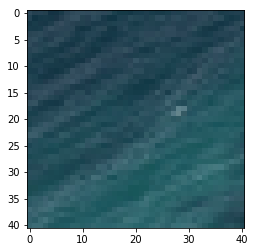

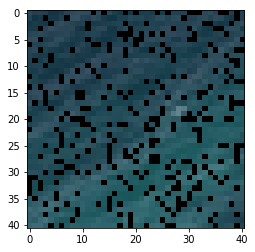

100 100


In [3]:
plt.ion()
img = read_img(IMG_FILE)
patch = get_patch(100, 100, img)
noisy = noise_patch(patch)
show(patch)
show(noisy)
imgnew, oldpatch = remove_patch(100, 100, img)

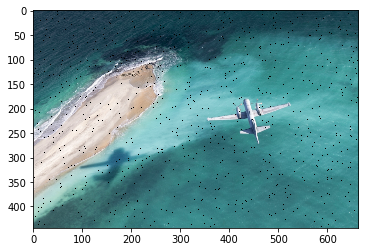

In [4]:
noisy_img = noise_patch(img, prc=.01)
show(noisy_img)

In [5]:
dict_patches, noisy_patches = get_patches(noisy_img, H, 1)

In [6]:
len(dict_patches), len(noisy_patches)

(3588, 176188)

## Inpainting Noise

In [7]:
class PatchesSelector:
    def __init__(self, alpha=.1):
        self.alpha = alpha
        
    def fit(self, patches_dict, noisy_patch):
        self.noisy_patch = noisy_patch
        #"""#build one regressor by channel...
        self.regressor_h = Lasso(alpha=self.alpha)
        self.regressor_s = Lasso(alpha=self.alpha)
        self.regressor_v = Lasso(alpha=self.alpha)
        #prepare data
        (x_h, x_s, x_v), (y_h, y_s, y_v) = ([], [], []), ([], [], [])
        for i in range(patches_dict[0].shape[0]):
            for j in range(patches_dict[0].shape[1]):
                if not DEAD in noisy_patch[i, j]:
                    x_h.append(np.array(patches_dict)[:, i, j, 0].flatten())
                    x_s.append(np.array(patches_dict)[:, i, j, 1].flatten())
                    x_v.append(np.array(patches_dict)[:, i, j, 2].flatten())
                    y_h.append(noisy_patch[i, j, 0])
                    y_s.append(noisy_patch[i, j, 1])
                    y_v.append(noisy_patch[i, j, 2])
        #fit the regressors
        self.regressor_h.fit(x_h, y_h)
        self.regressor_s.fit(x_s, y_s)
        self.regressor_v.fit(x_v, y_v)
        """
        patches_dict = np.array([p.flatten() for p in patches_dict]).T
        noisy_patch  = np.array(noisy_patch).flatten()
        self.regressor = Lasso(alpha=self.alpha)
        self.regressor.fit(patches_dict, noisy_patch)"""
        
    
    def reconstruct(self, patches_dict, noisy_patch=None):
        noisy_patch = self.noisy_patch if str(noisy_patch) == str(None) else noisy_patch
        noisy_patch = noisy_patch.copy()
        #try to reconstruct the image
        for i in range(noisy_patch.shape[0]):
            for j in range(noisy_patch.shape[1]):
                if DEAD in noisy_patch[i, j]:
                    h = self.regressor_h.predict([np.array(patches_dict)[:, i, j, 0]])[0]
                    s = self.regressor_s.predict([np.array(patches_dict)[:, i, j, 1]])[0]
                    v = self.regressor_v.predict([np.array(patches_dict)[:, i, j, 2]])[0]
                    noisy_patch[i, j, :] = np.array([h, s, v])
        return noisy_patch

In [8]:
#Test
d = np.array([
    [[[1, 1, 1], [0, 0, 0]], [[0, 0, 0], [0, 0, 0]]],
    [[[0, 0, 0], [1, 1, 1]], [[0, 0, 0], [0, 0, 0]]],
    [[[0, 0, 0], [0, 0, 0]], [[1, 1, 1], [0, 0, 0]]],
    [[[0, 0, 0], [0, 0, 0]], [[0, 0, 0], [1, 1, 1]]]
])

p = np.array([
    [[1, 1, 1], [0, 0, 0]], 
    [[0, 0, 0], [1, 1, 1]]
])

c = PatchesSelector(alpha=0.01)
c.fit(d, p)
#c.regressor_h.coef_
c.reconstruct(p)

array([[[1, 1, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 1, 1]]])

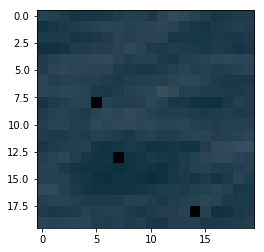

In [9]:
show(noisy_patches[1715])

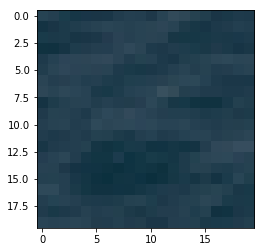

In [10]:
ps = PatchesSelector(alpha=0.001)
ps.fit(dict_patches, noisy_patches[1715])
show(ps.reconstruct(dict_patches))
#ps.regressor_h.coef_

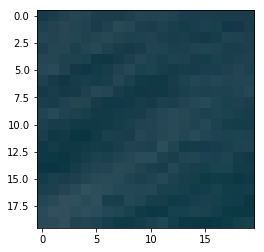

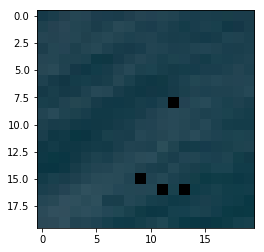

In [13]:
ps = PatchesSelector(alpha=0.001)
ps.fit(dict_patches, noisy_patches[205])
show(ps.reconstruct(dict_patches))
show(noisy_patches[205])

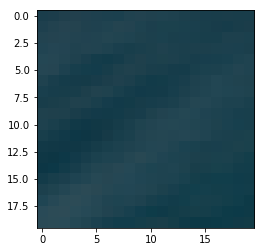

In [15]:
#reconstrution de la totalite d'un patch après avoir appris sa dcomposition
ps = PatchesSelector(alpha=0.0001)
ps.fit(dict_patches, noisy_patches[205])
rec = ps.reconstruct(dict_patches, noisy_patch=np.ones((H, H, 3)) * DEAD)
show(rec)
plt.show()

## Inpainting Patches

### Naive Way

100 220


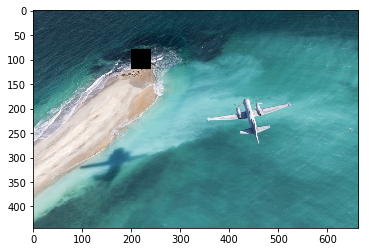

In [57]:
dropped_img = remove_patch(
    100, 220,
    img, 20
)[0]#, remove_patch(600, 770, img)[0]#)[0] #(160, 600, remove_patch(500, 800, img)[0])[0]
show(dropped_img)

In [58]:
reconstructed_img = dropped_img.copy()

In [59]:
reconstructed_img = dropped_img.copy()
dico, c = get_patches(dropped_img, H, 5)
dico = dico[:100] #limit the number of patches allowed for learning to improve speed !!!
for i in trange(len(reconstructed_img) - H):
    for j in range(len(reconstructed_img[0]) - H):
        if not reconstructed_img[i+H, j+H, 0] == DEAD:
            continue
        lasso = PatchesSelector(alpha=0.001)
        lasso.fit(dico, reconstructed_img[i:i+H, j:j+H, :])
        reconstructed_img[i+H, j+H] = lasso.reconstruct(dico)[-1, -1]

100%|██████████| 424/424 [03:14<00:00,  2.19it/s]


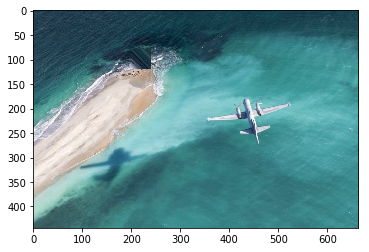

In [60]:
show(reconstructed_img)

### Better Heuristic !!!!!

In [61]:
X, Y = np.where(dropped_img[:, :, 0] == DEAD)

In [4]:
dico, c = get_patches(dropped_img, H, 5)
shuffle(dico)
dico = dico[:1500]
reconstructed_img = dropped_img.copy()

coords_to_fill = list(zip(X, Y))

def get_nbgs(i, j):
    out = []
    for ii in range(i - 1, i + 2):
        for jj in range(j - 1, j + 2):
            if (ii, jj) != (i, j):
                out.append((ii, jj))
    return out

def order_by_corner(L):
    L = L[:]
    ordered_list = []
    while L:
        ngbs = np.array(list(map(
                lambda c: len(list(filter(lambda c: c in L, get_nbgs(c[0], c[1])))),
                L
        )))
        t = []
        for i in np.where(ngbs == min(ngbs))[0]:
            ordered_list.append(L[i])
            t.append(L[i])
        for c in t:
            L.remove(c)
    return ordered_list

NameError: name 'dropped_img' is not defined

In [63]:
L = []
for i in range(6):
    for j in range(6):
        L.append((i, j))
shuffle(L)



M = np.zeros((6, 6))
ordered_list = order_by_corner(L)
for i in range(len(ordered_list)):
    M[ordered_list[i]] = i
M, ordered_list

array([[ 1.,  9., 12., 16.,  5.,  2.],
       [ 4., 22., 26., 29., 20.,  6.],
       [14., 30., 34., 32., 24., 18.],
       [17., 31., 35., 33., 28., 13.],
       [11., 23., 27., 25., 21.,  7.],
       [ 0.,  8., 15., 19., 10.,  3.]])

In [64]:
coords_to_fill = order_by_corner(coords_to_fill)
len(coords_to_fill)

1681

In [65]:
coords_to_fill_copy = coords_to_fill[:]

In [66]:
def hautDroite(img,x,y):
    return img[x-1, y-1, 0] != DEAD

def hautGauche(img,x,y):
    return img[x-1, y+1, 0] != DEAD

def basDroite(img,x,y):
    return img[x+1, y+1, 0] != DEAD

def basGauche(img,x,y):
    return img[x+1, y-1, 0] != DEAD



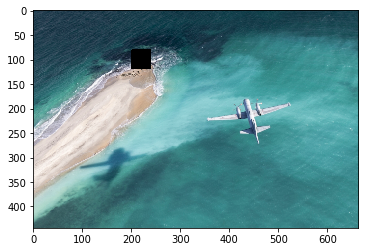

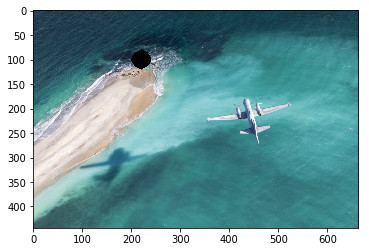

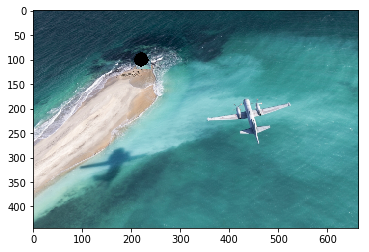

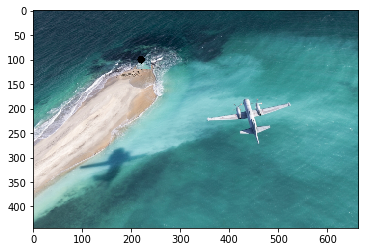

In [67]:
dico, c = get_patches(dropped_img, H, 5)
shuffle(dico)
dico = dico[:100]
reconstructed_img = dropped_img.copy()

for nb_pixel_reconstructed, (x, y) in enumerate(coords_to_fill_copy):
    xx, yy = x, y
    if hautDroite(reconstructed_img, x, y):
        x, y = x - H, y - H
        indx , indy = -1, 0
    elif hautGauche(reconstructed_img, x, y):
        x, y = x - H, y + H
        indx , indy = -1, -1
    elif basDroite(reconstructed_img, x, y):
        x, y = x + H, y + H
        indx , indy = 0, -1
    elif basGauche(reconstructed_img, x, y):
        x, y = x + H, y - H
        indx, indy = 0, 0

    lasso = PatchesSelector(alpha=0.01)
    lasso.fit(dico, reconstructed_img[x:x+H, y:y+H])
    rp = lasso.reconstruct(dico, reconstructed_img[x:x+H, y:y+H])
    reconstructed_img[xx, yy] = rp[indx, indy]
    #show each 100 reconstructed pixel how the program is doing...
    if nb_pixel_reconstructed % 500 == 0:
        show(reconstructed_img)


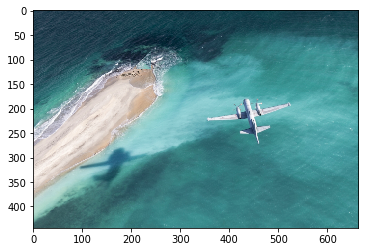

In [68]:
show(reconstructed_img)